# The problem:

Estimate the minimum time Dr. Roberts needs to wait to have an aluminum-clad cylinder of
mostly water go from 35 $^\circ$C to 10 $^\circ$C along with a corresponding (1 − $\alpha$)% confidence interval! For this, you will
need both a physical model, a computational implementation of it, and some manner (perhaps gut
feeling alone) to estimate how good you think your answer is. Very loosely, a (1 − $\alpha$)% CI for the
minimum waiting time $t_{min}$ reflects the range $L \textless t_{min} \textless U$ that you believe captures the true
value $t_{min}$ (1 − $\alpha$)% of the time.

The can has a height of 12 cm and a diameter of 6 cm.

## Assumptions:

The thermo-physical properties for water are static, values sourced at 10 $^\circ$C.

The can is entirely submerged and rotating at 1 revolution per second.

Reynolds number is calculated for a stirred vessel.

All boundary conditions are of type "Robin", assuming no heat transfer from a warm hand.

Heat transfer coefficient is calculated using a correlation from literature:  \
K. M. Becker, "Measurements of convective heat transfer from a horizontal cylinder \
       rotating in a tank of water," Int. J. Heat Mass Transf., vol. 6, no. 12, pp. 1053–1062, \
       1963, doi: 10.1016/0017-9310(63)90006-1

No mixing occurs in the can volume (representing a worst case).

Ice water bath is well mixed and has a uniform and unchanging temperature.

Thin aluminum wall is considered to have a negligible thermal resistance, and is not modeled.

The solution is considered converged when the relative difference between the last and second to last $t(\bar{T}=10 ^\circ C)$ is 
less than 0.1% (by default in convergenceTest(); can be set as a parameter).

## Solution Summary:

The spatio-temporal solution converged with 18 radial elements and 72 axial elements (uniform and square mesh elements) giving a $t_{final} = 876.5$ seconds. 
This represents our upper-bound as we can reasonably expect 
fluid inside the can to be mixing -- which is not modeled. 

The lower bound is found using lumped-parameter analysis with equivalent parameters and assumptions.
This assumes an effective conductivity for the internal volume of water that is much higher than reality (perfect mixing).
This results in a $t_{final} = 61.2$ seconds.

This gives a final answer of $61.2 \textless t_{actual} \textless 876.5$ seconds. A point solution, by our estimation would be closer in value to the upper bound: somewhere around $600$ seconds with constant spinning.

## Solution Implementation:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.sparse import csr_matrix
from starter_code import construct_system
import matplotlib.animation as animation

In [2]:
def Cool_can(N_r, t_initial, t_final, t_step, T0=None):
    """
    Simulates transient cooling of "beverage" can using finite volume discretization 
    in cylindrical coordinates and solves the heat equation using implicit time integration.

    The simulation assumes no internal heat generation and convection-based boundary 
    conditions on all surfaces of the can. The domain is discretized radially and axially, 
    and the resulting system of ODEs is solved using `scipy.integrate.solve_ivp`.

    Parameters:
    ----------
    N_r : int
        Number of discretization cells in the radial direction. Axial discretization is calculated 
        assuming square cells given the can dimensions
    t_initial : float
        Initial time for the simulation [seconds].
    t_final : float
        Final time for the simulation [seconds].
    t_step : float
        Time step for evaluation [seconds].
    T0 : int, float, or np.ndarray, optional
        Initial temperature [°C]. Can be a scalar (uniform temperature) or an array matching
        the number of spatial cells (N_z * N_r) for non-uniform initial conditions. 
        If None, a default of 35°C is used.

    Returns:
    -------
    t_initial : float
        The initial simulation time [seconds]. (Useful for autimated tests defined elswhere)
    t_final : float
        The final simulation time [seconds]. (Useful for autimated tests defined elswhere)
    T_bar : np.ndarray
        Spatially averaged temperature of the can [°C] at t_i, accounting for cylindrical 
        volume weighting.
    T_map : np.ndarray
        3D array of shape (time_steps, N_z, N_r) representing the temperature distribution 
        over time within the can.

    Notes:
    -----
    - Material properties (thermal conductivity, specific heat, viscosity) are hardcoded 
      for water at 10°C.
    - The heat transfer coefficient is calculated from a Nusselt number correlation assuming 
      external convection. Correlation from:
      K. M. Becker, "Measurements of convective heat transfer from a horizontal cylinder 
      rotating in a tank of water," Int. J. Heat Mass Transf., vol. 6, no. 12, pp. 1053–1062, 
      1963, doi: 10.1016/0017-9310(63)90006-1
    - The function internally constructs the discretized spatial system using a call to 
      `construct_system()`, which must be defined elsewhere.
    - Boundary conditions are Robin-type (convection) on all external surfaces.
    """
    def T_prime(t, T, A, b, rho, c_p):
        return (b - A@T)/rho/c_p
    
    h = 0.12
    r = 0.03
    d = 2*r
    
    kfun = lambda r, z : 0.58 #[W m-1 K-1] @ 10 C not assuming effective conductivity
    qppp = lambda r, z : 0 # no heat gen in can
    
    k = kfun(0,0)
    mu = 17.916e-4 # {Pa*s}
    rho = 1000 # ~{kg/m^3}
    w = np.pi*d # {m/s}
    c_p = 4.18 * 1000 # {J/kg*K}
    
    Re = rho * w * d / mu
    Pr = c_p * mu / k
    Nu = 0.133 * Re**(2/3) * Pr**(1/3)
    HTC = Nu*k/d
    T_oo = 0 # {C}
    
    #set Boundary Conditions
    BC_z = ('robin', HTC, T_oo)
    BC_r_top = ('robin', HTC, T_oo)
    BC_r_bottom = ('robin', HTC, T_oo)

    #discretization 
    #N_r = 30
    N_z = int((h/r)*N_r) #equal delta in h and r directions

    r_edge = np.linspace(0, r, N_r+1)
    z_edge = np.linspace(0, h, N_z+1)

    r_center = (r_edge[:-1]+r_edge[1:])/2
    z_center = z_edge[:-1]+z_edge[1:]/2

    A, b = construct_system(r_center, z_center, kfun, qppp,
                        BC_z, BC_r_top, BC_r_bottom)
    #Use sparse matrices for calculations to speed up solving
    A_spc = csr_matrix(A)
    
    #Logic to set initial temperature using assumed value, given value, or map (used if extending the solution time)
    try:
        if T0 == None: T0 = 35
    except: pass 
    if type(T0) == int: T0 = T0 * np.ones(A.shape[0]) # {deg C}
    elif type(T0) == np.ndarray: T0 = T0.flatten()
    else: raise "Missing Initial Temperature Map"

    t_eval = np.arange(t_initial, t_final+t_step, t_step, dtype=np.float64) # Evaluate at times listed (t_final is last in the list)
    
    sol = solve_ivp(T_prime, [t_initial, t_final+t_step], T0, 
                    args=(A_spc, b, rho, c_p),
                    t_eval=t_eval,
                    method='BDF')

    # Properly weight the cells as a pie slice for average temperature calculation
    r_weights = np.array([r_edge[-(i+1)]**2 - r_edge[-(i+2)]**2 for i in range(N_r)])
    r_weights_norm = np.flip(r_weights/sum(r_weights))
    # Calculate T_bar
    T_bar = np.zeros_like(t_eval)
    for i in range(len(T_bar)):
        T_bar[i] = sum(sum(sol.y[:,i].reshape((N_z, N_r))*r_weights_norm))/N_z

    return t_initial, t_final, T_bar, sol.y.T.reshape((-1, N_z, N_r))
    

In [3]:
def valCross(dep,ind,ths):
    """
    A very incomplete interpolation funtion to find the value of `ind` 
    corresponding to a threshold `ths` in the dependent variable `dep`, 
    assuming `dep` is in descending order.

    The function searches for the first point where `dep` drops below `ths`, 
    and linearly interpolates between surrounding points to estimate `ind(ths)`.

    Breaks if `ths` > `dep[0]` (index error) or if `dep` is not strictly decreasing 
    (undetermined output).

    Parameters
    ----------
    dep : array-like
        Dependent variable values (must be strictly descending).
    ind : array-like
        Independent variable values corresponding to `dep`.
    ths : float
        Threshold value to locate within `dep` (must be less than dep[0]).

    Returns
    -------
    float
        Interpolated value of `ind` at the threshold `ths`.

    Raises
    ------
    ValueError
        If `ths` is not crossed by any value in `dep`.

    """
    for i in range(len(dep)-1):
        if dep[i] < dep[i+1]:
            raise ValueError("Values of 'dep' must be strictly decreasing.")
    if ths > dep[0]:
        raise ValueError("Threshold is higher than range of dep.")
    
    for i in range(len(dep)):
        if dep[i] < ths:
            return (ind[i-1]-ind[i])/(dep[i-1]-dep[i])*(ths-dep[i]) + ind[i]
        elif dep[i] == ths:
            return ind[i]
    raise ValueError("Threshold was not crossed by dep.")


In [4]:
def genPlots(vals, errs, N_r):
    """
    Generates a two-panel plot to visualize the results of a convergence analysis.

    The function creates:
      - A top subplot showing the time at which a temperature threshold is reached 
        as a function of the number of mesh points (N_r).
      - A bottom subplot showing the corresponding relative errors on a logarithmic scale.

    Parameters
    ----------
    vals : array-like
        Time values (e.g., when a temperature threshold is crossed), typically from 
        a convergence test.
    errs : array-like
        Relative errors corresponding to the values in `vals`.
    N_r : array-like
        Number of mesh points used in the radial direction for each test case.

    Returns
    -------
    None
        This function only displays the plot and does not return any values.
    """
    # --- 1. Plot temperature and relative error on shared x-axis ---
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 6), gridspec_kw={'height_ratios': [2, 1]})
    
    # Top plot: Temperature values
    ax1.plot(N_r, vals, marker='o', color='steelblue', label='Temperature')
    ax1.set_ylabel("Time (s)")
    ax1.set_title("Convergence Analysis")
    ax1.grid(True)
    ax1.legend()

    # Bottom plot: Relative errors
    ax2.semilogy(N_r, errs, marker='s', color='darkorange', label='Relative Error')
    ax2.set_xlabel("Number of Mesh Points (N_r)")
    ax2.set_ylabel("Relative Error")
    ax2.grid(True)
    ax2.legend()


    plt.tight_layout()
    plt.show()

In [5]:
def convergenceTest(N_r_initial=2, t_initial=0, t_final=900, t_step=20, diff_percent=0.1, max_itr=20, gen_plots=False):
    """
    Performs a convergence test to determine the required mesh density (N_r)
    for accurately predicting when the average temperature of the "beverage" can
    reaches a specified threshold.

    The test iteratively increases the number of radial mesh points until the 
    change in time (at which T_bar crosses T_thres) between successive refinements is within
    a specified relative difference.

    If the temperature threshold is not reached within the initial simulation 
    time, `t_final` is extended automatically with the final condition set as the new
    initial temperature map (now spacially dependent)

    Parameters
    ----------
    N_r_initial : int, optional
        Initial number of mesh points in the radial direction. Default is 2.
    t_initial : float, optional
        Start time of the simulation [seconds]. Default is 0.
    t_final : float, optional
        Initial end time of the simulation [seconds]. Default is 900.
    t_step : float, optional
        Time step for evaluating the solution [seconds]. Default is 20.
    diff_percent : float, optional
        Maximum allowable relative difference (%) in threshold-crossing time
        between iterations for convergence. Default is 0.1.
    max_itr : int, optional
        Maximum number of refinement iterations. Default is 20.
    gen_plots : bool, optional
        If True, generates convergence plots of threshold-crossing time and 
        relative error vs. mesh density. Default is False.

    Returns
    -------
    t_start : float
        The initial simulation time [seconds] given for the final call of Cool_can(). Not necessarily the default initial
        time if the simulation time is extended to reach a solution.
    t_end : float
        The final simulation time [seconds] of the converged answer.
    T_bar : np.ndarray
        Spatially averaged temperature of the can over time [°C], accounting for cylindrical 
        volume weighting.
    T_map : np.ndarray
        3D array of shape (time_steps, N_z, N_r), representing the temperature 
        distribution in the can over time at the converged mesh resolution.

    Raises
    ------
    ValueError
        If the convergence condition is not met within `max_itr` iterations.

    Notes
    -----
    - The function assumes that the can's average temperature is used for 
      determining when the threshold is crossed.
    - Uses `Cool_can()` for simulation and `valCross()` for interpolation.
    - Threshold temperature is hardcoded to 10°C per problem statement.
    """
    
    T_thres = 10 #deg C set by problem statement
    extend_mesh = 2 # number of mesh elements is increased by value after each iteration
    t_extend = 200 #if the threshold temp is not reached, t_final is extended and T is recalculated
    N_r = [N_r_initial]

    rel_diff = [] #
    t_cross = [1] #Time at which the temperature threshold is crossed
    
    for i in range(max_itr):
        t_start, t_end, T_bar, T_map = Cool_can(N_r[i], t_initial,
                                                         t_final, t_step)
        while T_bar[-1] > T_thres:
            print("Iteration {}: threshold not crossed...increasing time to {}s".format(i,t_end+t_extend))
            t_start, t_end, T_bar, T_map = Cool_can(N_r[i], t_end, 
                                                             t_end+t_extend, t_step,
                                                             T0=T_map[-1])
        t_eval = np.arange(t_start, t_end+t_step, t_step, dtype=float)
        t_cross.append(valCross(T_bar,t_eval,T_thres))
        rel_diff.append((abs(t_cross[i+1]-t_cross[i])/t_cross[i]*100))
        if rel_diff[i] < diff_percent:
            print("System converged on step {} at N_r={}".format(i+1,N_r[-1]))
            print("The average temperature of the bevi reached {} C in {:.1f} seconds.".format(T_thres,t_cross[-1]))
            if gen_plots: genPlots(np.array(t_cross[1:]), np.array(rel_diff), N_r)
            return t_start, t_end, T_bar,T_map

        N_r.append(N_r[-1] + extend_mesh)
        
    raise ValueError("Max number of iterations exceeded: value did not converge.")

Iteration 0: threshold not crossed...increasing time to 1100s
Iteration 0: threshold not crossed...increasing time to 1300s
Iteration 1: threshold not crossed...increasing time to 1100s
System converged on step 9 at N_r=18
The average temperature of the bevi reached 10 C in 876.5 seconds.


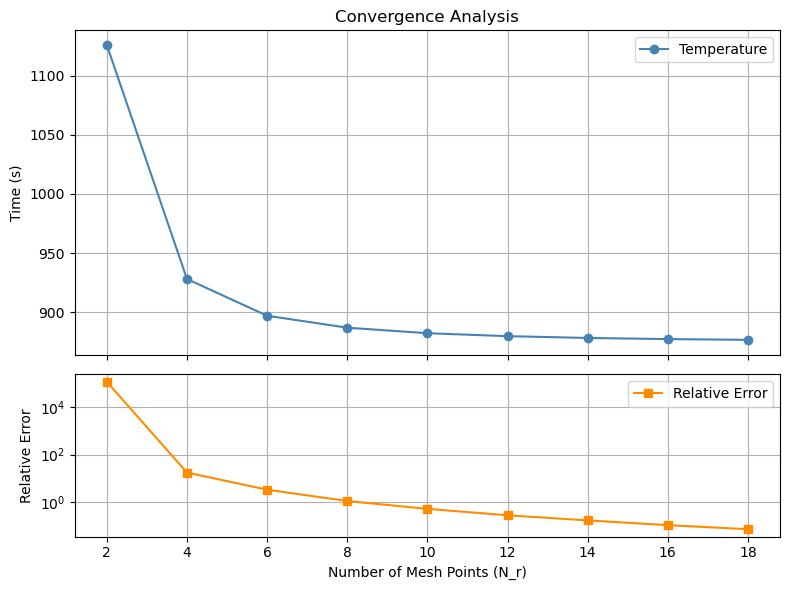

In [6]:
#Run the adaptive convergence test
t_start, t_end, T_bar, con_T_map = convergenceTest(gen_plots=True)

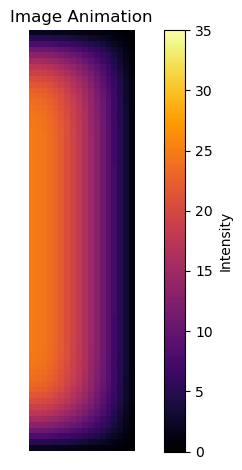

In [7]:
#Animate and save as a .gif the final iteration of the convergence test's time dependent temperatures

imgs = con_T_map
fig, ax = plt.subplots()

max_val = np.max(imgs)
im = ax.imshow(imgs[0], cmap='inferno', vmin=0, vmax=max_val)
cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Intensity")

def update(frame):
    im.set_data(imgs[frame])
    return [im]

ani = animation.FuncAnimation(fig, update, frames=len(imgs), blit=True, interval=200)
ani.save("Temp_Animation.gif",writer='pillow')
plt.title("Image Animation")
plt.axis('off')
plt.tight_layout()
plt.show()

In [8]:
#Lumped parameter analysis:
def T_prime(t, T_bar, C, U, Qdot, T_oo):
    return (Qdot(t)-U(t)*(T_bar-T_oo(t)))/C

V = .03**2 * np.pi * 0.12
SA = np.pi*(2*.03**2 + 0.06*0.12)

T0 = 35.0 #100.0
C = 1000 * 4220 * V # # 10
U = lambda t: 1040 * SA
Qdot = lambda t: 0.0
T_oo = lambda t: 0.0 # 35.0

t_step = 20
t_eval = np.arange(t_start, t_end+t_step, t_step, dtype=float)

lump_sol = solve_ivp(T_prime, [t_start, t_end+t_step], [T0], 
                args=(C, U, Qdot, T_oo),
                t_eval=t_eval)

The average temperature of the bevi reached 10 C in 61.2 seconds.


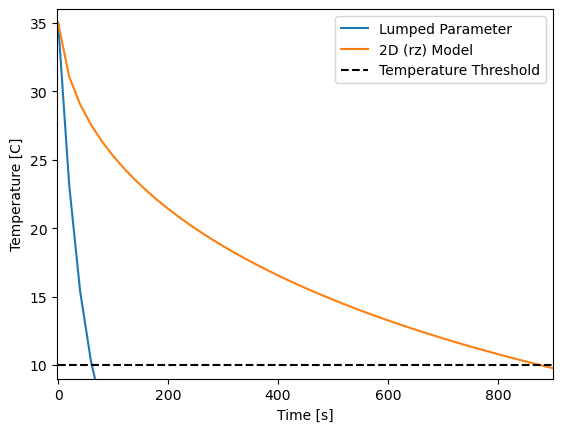

In [17]:
# plot 2D solution compared to lumped parameter analysis
plt.plot(t_eval,lump_sol.y[0],label='Lumped Parameter')
plt.plot(t_eval,T_bar,label='2D (rz) Model')
plt.plot(t_eval,10*np.ones_like(t_eval),'k--',label='Temperature Threshold')
plt.ylim((9,36))
plt.xlim((-2,t_end))
plt.xlabel("Time [s]")
plt.ylabel("Temperature [C]")
plt.legend()

print("The average temperature of the bevi reached {} C in {:.1f} seconds.".format(10,valCross(lump_sol.y[0],t_eval,10)))